In [1]:
import pickle
import time
import numpy as np
# from music21 import converter, instrument, note, chord, stream
# import glob

from sklearn.model_selection import train_test_split
from numpy.random import choice
from collections import OrderedDict

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Flatten, Concatenate, Activation, Lambda
from keras.layers import BatchNormalization as BatchNorm
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import SGD, Adam
# from keras.layers import LSTM
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

print(tf.__version__)

2.13.0


In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2023-08-05 14:29:37.671369: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-08-05 14:29:37.671385: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-05 14:29:37.671390: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-05 14:29:37.671834: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-05 14:29:37.672070: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
with open('X_array_22050.pkl', 'rb') as file:
    X = pickle.load(file)
with open('L_array_44100.pkl', 'rb') as file:
    labels = pickle.load(file)

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=74)
del(X)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((520, 661500, 2), (130, 661500, 2), (520,), (130,))

# Introduce the convolutional networks
### The output is not a classifier and instead a numeric value

In [4]:
### 1D WAVEFORM PARALLEL CONVOLUTION MODEL

def create_model_1(n_samples):
    # Mid and side inputs
    input_mid = Input(shape = (n_samples, 1))
    input_side = Input(shape = (n_samples, 1))

    # Convolutional layers for sequence 1
    conv_mid = Conv1D(32, 100, activation='relu')(input_mid)
    conv_mid = MaxPooling1D(2)(conv_mid)
    conv_mid = BatchNorm()(conv_mid)
    conv_mid = Conv1D(64, 100, activation='relu')(conv_mid)
    conv_mid = MaxPooling1D(2)(conv_mid)
    conv_mid = BatchNorm()(conv_mid)
    #conv_mid = Flatten()(conv_mid)

    # Convolutional layers for sequence 2
    conv_side = Conv1D(32, 100, activation='relu')(input_side)
    conv_side = MaxPooling1D(2)(conv_side)
    conv_side = BatchNorm()(conv_side)
    conv_side = Conv1D(64, 100, activation='relu')(conv_side)
    conv_side = MaxPooling1D(2)(conv_side)
    conv_side = BatchNorm()(conv_side)
    #conv_side = Flatten()(conv_side)

    # Concatenate the representations of both sequences
    combined = Concatenate()([conv_mid, conv_side])

    # Fully connected -> output
    combined = Dense(64, activation='relu')(combined)
    combined = Dense(16, activation='relu')(combined)
    prediction = Dense(1, activation='sigmoid')(combined)

    # Create the model with two inputs and one output
    model = Model(inputs=[input_mid, input_side], outputs=prediction)

    return model

# Create the regression CNN model
#model_1D_wave = create_model_1(X.shape[1]) # Shape is that of one 30 sec sequence, length 1323000
#model_1D_wave = create_model_1(661500)

# Compile the model for regression
#model_1D_wave.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Print a summary of the model architecture
#model_1D_wave.summary()

In [5]:
### 2D WAVEFORM PARALLEL CONVOLUTION MODEL

def create_model_2(resize_shape):
    # Mid and side inputs
    input_mid = Input(shape = resize_shape)
    input_side = Input(shape = resize_shape)

    # Convolutional layers for sequence 1
    conv_mid = Conv2D(32, (45, 10), activation='relu')(input_mid)
    conv_mid = MaxPooling2D(3, 2)(conv_mid)
    conv_mid = BatchNorm()(conv_mid)
    conv_mid = Conv2D(64, (45, 10), activation='relu')(conv_mid)
    conv_mid = MaxPooling2D(3, 2)(conv_mid)
    conv_mid = BatchNorm()(conv_mid)
    conv_mid = Flatten()(conv_mid)

    # Convolutional layers for sequence 2
    conv_side = Conv2D(32, (45, 10), activation='relu')(input_side)
    conv_side = MaxPooling2D(3, 2)(conv_side)
    conv_side = BatchNorm()(conv_side)
    conv_side = Conv2D(64, (45, 10), activation='relu')(conv_side)
    conv_side = MaxPooling2D(3, 2)(conv_side)
    conv_side = BatchNorm()(conv_side)
    conv_side = Flatten()(conv_side)

    # Concatenate the representations of both sequences
    combined = Concatenate()([conv_mid, conv_side])

    # Fully connected -> output
    combined = Dense(64, activation='relu')(combined)
    combined = BatchNorm()(combined)
    combined = Dense(16, activation='relu')(combined)
    combined = BatchNorm()(combined)
    prediction = Dense(1, activation='sigmoid')(combined)

    # Create the model with two inputs and one output
    model = Model(inputs=[input_mid, input_side], outputs=prediction)

    return model

# Create model
# Shape is one (6615, 200) or one 30 sec window split into 200 windows
# factors are 3,3,3,5,7,7 and 2,2,2,5,5
model_2D_wave = create_model_2((6615, 100, 1))

# Compile the model for regression
opt = Adam(learning_rate=0.01)
model_2D_wave.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_absolute_error'])

# Print a summary of the model architecture
model_2D_wave.summary()

2023-08-05 14:30:09.755563: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-05 14:30:09.755598: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 6615, 100, 1)]       0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 6615, 100, 1)]       0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 6571, 91, 32)         14432     ['input_1[0][0]']             
                                                                                                  
 conv2d_2 (Conv2D)           (None, 6571, 91, 32)         14432     ['input_2[0][0]']             
                                                                                              

# Train the model

In [6]:
# ((520, 1323000, 2), (130, 1323000, 2), (520,), (130,))

def train_network(model):
    checkpoint = ModelCheckpoint(
        #"weights2-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5",
        "2DWav_wBest.hdf5",
        monitor='val_loss',
        verbose=1,
        save_weights_only=True,
        save_best_only=True,
        mode='min'
    )

    callbacks_list = [checkpoint]

    history = model.fit(x=[X_train[:,:,0].reshape((520, 6615, 100)), X_train[:,:,1].reshape((520, 6615, 100))], y=y_train, batch_size=4, epochs=20, validation_data = ([X_test[:,:,0].reshape((130, 6615, 100)),X_test[:,:,1].reshape((130, 6615, 100))], y_test), callbacks = callbacks_list)
    # model.save_weights('drive/MyDrive/Spotify feature classification/Code/Data and Weights/2DWav_wCurrent.h5')
    model.save_weights('2DWav_wCurrent.h5')

    # file_path = '2DWav_wBest.hdf5'
    # destination_path = 'drive/MyDrive/Spotify feature classification/Code/Data and Weights/'
    # shutil.copyfile(file_path, destination_path + '2DWav_wBest.hdf5')

    return history

# (6615, 100)
#X_2D_mid_train = X_train[:,:,0].reshape((520, 6615, 100))
#X_2D_side_train = X_train[:,:,1].reshape((520, 6615, 100))
#X_2D_mid_test = X_test[:,:,0].reshape((130, 6615, 100))
#X_2D_side_test = X_test[:,:,1].reshape((130, 6615, 100))

hist = train_network(model_2D_wave)

Epoch 1/20


2023-08-05 11:24:00.854713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


130/130 [==============================] - ETA: 0s - loss: 0.0527 - mean_absolute_error: 0.1892

2023-08-05 11:29:17.692282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.37326, saving model to 2DWav_wBest.hdf5
130/130 [==============================] - 341s 3s/step - loss: 0.0527 - mean_absolute_error: 0.1892 - val_loss: 0.3733 - val_mean_absolute_error: 0.5748
Epoch 2/20
130/130 [==============================] - ETA: 0s - loss: 0.0440 - mean_absolute_error: 0.1758
Epoch 2: val_loss improved from 0.37326 to 0.14717, saving model to 2DWav_wBest.hdf5
130/130 [==============================] - 332s 3s/step - loss: 0.0440 - mean_absolute_error: 0.1758 - val_loss: 0.1472 - val_mean_absolute_error: 0.3264
Epoch 3/20
130/130 [==============================] - ETA: 0s - loss: 0.0428 - mean_absolute_error: 0.1718 
Epoch 3: val_loss did not improve from 0.14717
130/130 [==============================] - 3248s 25s/step - loss: 0.0428 - mean_absolute_error: 0.1718 - val_loss: 0.3711 - val_mean_absolute_error: 0.5731
Epoch 4/20
130/130 [==============================] - ETA: 0s - loss: 0.0437 - mean_absolute_error: 0.1752


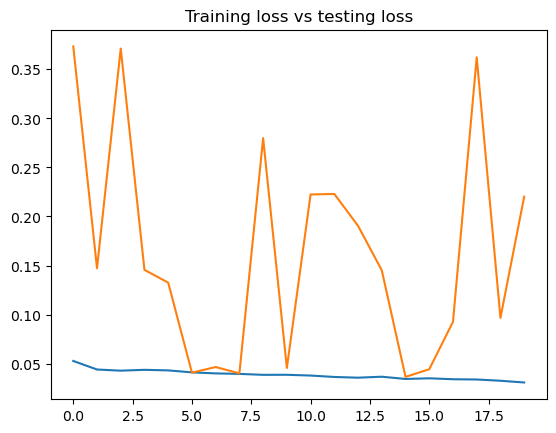

In [9]:
import matplotlib.pyplot as plt

plt.title("Training loss vs testing loss")
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

# Test the model and plot results
Accuracy is measured in mean error, standard deviation, and correlation

In [6]:
#model_2D_wave = create_model_2((6615, 100, 1))
model_2D_wave.load_weights('2DWav_wCurrent.h5')

def correlation_coefficient(X, Y):
    # Check if both arrays have the same length
    if len(X) != len(Y):
        raise ValueError("Both arrays must have the same length.")

    n = len(X)

    # Calculate the means of both arrays
    mean_X = np.mean(X)
    mean_Y = np.mean(Y)

    # Calculate the numerator of the correlation coefficient
    numerator = np.sum((X - mean_X) * (Y - mean_Y))

    # Calculate the denominator of the correlation coefficient
    denominator = np.sqrt(np.sum((X - mean_X)**2) * np.sum((Y - mean_Y)**2))

    # Calculate the correlation coefficient (r)
    r = numerator / denominator

    return r

In [10]:
# X_2D_mid_train = X_train[:,:,0].reshape((520, 6615, 100))
# X_2D_side_train = X_train[:,:,1].reshape((520, 6615, 100))
# X_2D_mid_test = X_test[:,:,0].reshape((130, 6615, 100))
# X_2D_side_test = X_test[:,:,1].reshape((130, 6615, 100))

train_pred = model_2D_wave.predict([X_train[:,:,0].reshape((520, 6615, 100)), X_train[:,:,1].reshape((520, 6615, 100))])
test_pred = model_2D_wave.predict([X_test[:,:,0].reshape((130, 6615, 100)), X_test[:,:,1].reshape((130, 6615, 100))])
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

train_error = np.sum(np.abs(train_pred - y_train))/len(y_train)
test_error = np.sum(np.abs(test_pred - y_test))/len(y_test)
print("Average training error (absolute):", train_error)
print("Average testing error (absolute):", test_error)
print()
print("Standard deviation of train error:", np.sqrt(np.sum(np.abs(np.abs(train_pred - y_train)-train_error))/len(y_train)))
print("Standard deviation of test error:", np.sqrt(np.sum(np.abs(np.abs(test_pred - y_test)-test_error))/len(y_test)))
print()
train_error = np.sum(np.square(train_pred - y_train))/len(y_train)
test_error = np.sum(np.square(test_pred - y_test))/len(y_test)
print("Average training error (square):", train_error)
print("Average testing error (square):", test_error)
print()
### Chance to be significantly off
print(len(y_train[np.abs(train_pred - y_train) > 0.2]) / len(y_train))
print(len(y_test[np.abs(test_pred - y_test) > 0.2]) / len(y_test))
print()
result = correlation_coefficient(train_pred, y_train.reshape(-1, 1))
print("Correlation coefficient train:", result)
result = correlation_coefficient(test_pred, y_test.reshape(-1, 1))
print("Correlation coefficient test:", result)

5/5 [==============================] - 20s 5s/step
Average training error (absolute): 0.13323120025885793
Average testing error (absolute): 0.15839107714772224

Standard deviation of train error: 0.2803056387072656
Standard deviation of test error: 0.2967463055539454

Average training error (square): 0.027610549068504547
Average testing error (square): 0.036514355341235205

0.2153846153846154
0.3769230769230769

Correlation coefficient train: 0.652510683472066
Correlation coefficient test: 0.4899000527580943


### Best testing iteration

In [11]:
model_2D_wave.load_weights('2DWav_wBest.hdf5')

train_pred = model_2D_wave.predict([X_train[:,:,0].reshape((520, 6615, 100)), X_train[:,:,1].reshape((520, 6615, 100))])
test_pred = model_2D_wave.predict([X_test[:,:,0].reshape((130, 6615, 100)), X_test[:,:,1].reshape((130, 6615, 100))])
print()
train_error = np.sum(np.abs(train_pred - y_train))/len(y_train)
test_error = np.sum(np.abs(test_pred - y_test))/len(y_test)
print("Average training error (absolute):", train_error)
print("Average testing error (absolute):", test_error)
print()
print("Standard deviation of train error:", np.sqrt(np.sum(np.abs(np.abs(train_pred - y_train)-train_error))/len(y_train)))
print("Standard deviation of test error:", np.sqrt(np.sum(np.abs(np.abs(test_pred - y_test)-test_error))/len(y_test)))
print()
train_error = np.sum(np.square(train_pred - y_train))/len(y_train)
test_error = np.sum(np.square(test_pred - y_test))/len(y_test)
print("Average training error (square):", train_error)
print("Average testing error (square):", test_error)
print()
print(len(y_train[np.abs(train_pred - y_train) > 0.2]) / len(y_train), "% training are significantly off.")
print(len(y_test[np.abs(test_pred - y_test) > 0.2]) / len(y_test), "% testing are significantly off.")
print()
result = correlation_coefficient(train_pred, y_train.reshape(-1, 1))
print("Correlation coefficient train:", result)
result = correlation_coefficient(test_pred, y_test.reshape(-1, 1))
print("Correlation coefficient test:", result)

5/5 [==============================] - 20s 5s/step

Average training error (absolute): 0.13309815611686843
Average testing error (absolute): 0.15839107714772224

Standard deviation of train error: 0.28050075501695004
Standard deviation of test error: 0.2967463055539454

Average training error (square): 0.0275990962223731
Average testing error (square): 0.036514355341235205

0.2153846153846154 % training are significantly off.
0.3769230769230769 % testing are significantly off.

Correlation coefficient train: 0.6524692902253941
Correlation coefficient test: 0.4899000527580943
